In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import scipy
import math

In [2]:
data = pd.read_csv('data/legend.csv')
data.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


In [3]:
list = []
for i in range(0,300):
    A = cv2.imread('images/'+data.iloc[i,1])
    B = cv2.resize(A, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    list.append(B)
list = np.array(list)

In [4]:
print(data['emotion'].str.lower().unique())

['anger' 'surprise' 'disgust' 'fear' 'neutral' 'happiness' 'sadness'
 'contempt']


In [5]:
data['emotion'] = data['emotion'].str.lower()
print(data['emotion'].str.lower().unique())
type_y = data['emotion'].str.lower().unique()
type(type_y)

['anger' 'surprise' 'disgust' 'fear' 'neutral' 'happiness' 'sadness'
 'contempt']


numpy.ndarray

In [6]:
train_X_orig = list
y = []
for i in range(0,300):
    out = data.iloc[i,2]
    A = np.zeros((type_y.size))
    for j in range(0,type_y.size):
        if type_y[j]==out:
            A[j] = 1
            break
    y.append(A)
train_y = np.array(y)
train_y_orig = train_y.T

In [7]:
shape_X = train_X_orig.shape
shape_y = train_y_orig.shape
print("Shape of X : ",shape_X)
print("Shape of y : ",shape_y)

Shape of X :  (300, 64, 64, 3)
Shape of y :  (8, 300)


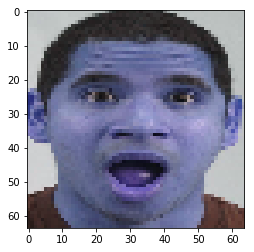

[ 0.  1.  0.  0.  0.  0.  0.  0.]


In [8]:
X_temp = np.array(train_X_orig[1])
plt.imshow(X_temp,interpolation='nearest')
plt.show()
print(train_y_orig[:,1])

In [9]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A,cache

In [10]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A,cache

In [11]:
def softmax(Z):
    #print(Z.shape)
    t = np.zeros((Z.shape[0],Z.shape[1]))
    for i in range(0,Z.shape[0]):
        for j in range(0,Z.shape[1]):
            t[i,j] = math.exp(Z[i,j])
    s = np.sum(t)
    A = np.array([[i / s for i in t]])
    A = A.reshape(Z.shape[0],Z.shape[1])
    #print(t)
    #print(A)
    cache = Z
    return A,s,cache

In [12]:
Z = np.array([[5.,2.,-1.,3.]])
a,b,c = softmax(Z)

In [13]:
def sigmoid_backward(dA,Z):
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [14]:
def relu_backward(dA,Z):
    dZ = np.array(dA,copy=True)
    dZ[Z<=0] = 0
    return dZ

In [15]:
def softmax_backward(y,y_hat):
    dZ = -y + y_hat(np.sum(y))
    return dZ

In [16]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    # Initializing W's and b's
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [17]:
def linear_forward(A,W,b):
    Z = W.dot(A)+b
    cache = (A,W,b)
    return Z,cache

In [18]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation=="sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation=="relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    elif activation=="softmax":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,s,activation_cache = softmax(Z) 
        #parameters['S'] = s
    cache = (linear_cache,activation_cache)
    return A,cache

In [19]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L =len(parameters)//2
    for l in range(1,L):
        A_prev = A
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        A,cache = linear_activation_forward(A_prev,W,b,"relu")
        caches.append(cache)
    W,b = parameters['W'+str(L)],parameters['b'+str(L)]
    AL,cache = linear_activation_forward(A,W,b,'softmax')
    caches.append(cache)
    return AL,caches

In [20]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost = (1.0/m)*np.sum(-Y*np.log(AL)-(1-Y)*np.log(1-AL))
    #cost = -(1.0/m)*np.sum(np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    return cost

In [21]:
def linear_backward(dZ,cache):
    A_prev,W,b = cache
    m = A_prev.shape[1]
    dW = (1.0/m)*dZ.dot(A_prev.T)
    db = (1.0/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = W.T.dot(dZ)
    return dA_prev,dW,db

In [22]:
def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache = cache
    if activation=="relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
    elif activation=="sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev,dW,dB = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [32]:
def L_model_backward(AL,Y,caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # last layer back propagation
    dZL = AL - Y
    current_cache = caches[L-1]
    grads["dA"+str(L)],grads['dW'+str(L)],grads['db'+str(L)] = linear_backward(dZL,current_cache[0])
    
    # Backpropagation for other layers.
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA'+str(l+1)],grads['dW'+str(l+1)],grads['db'+str(l+1)] = linear_activation_backward(grads['dA'+str(l+2)],current_cache,"relu")
    return grads

In [39]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 
    v = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        
    return v

In [60]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        v["dW" + str(l+1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l+1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)] - learning_rate*v["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)] - learning_rate*v["db"+str(l+1)]
        
    return parameters, v

In [62]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

In [69]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.0049,beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                        
    
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
        
    return parameters, v, s

In [24]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*grads['db'+str(l+1)]
    return parameters

In [25]:
train_X_flatten = train_X_orig.reshape(train_X_orig.shape[0],-1).T
train_X = train_X_flatten/255
train_y = train_y_orig
print("train_X shape : ",train_X.shape)
print("train_y shape : ",train_y.shape)

train_X shape :  (12288, 300)
train_y shape :  (8, 300)


In [76]:
layers_dims = [train_X.shape[0],80,20,15,11,8]

In [74]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=700,print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    v = initialize_velocity(parameters)
    for i in range(0,num_iterations):
        AL,caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        parameters,v = update_parameters_with_momentum(parameters,grads,v,beta=0.9,learning_rate=learning_rate)
        if print_cost and i%100==0:
            print(AL[:,0])
            print("Cost after iteration %i : "%(i),end="")
            print(cost)
            costs.append(cost)
    #Plotting cost function.
    plt.plot(np.squeeze(costs))
    plt.ylabel('Costs')
    plt.xlabel('Iterations (per tens)')
    plt.title("Learning Rate = "+str(learning_rate))
    plt.show()
    return parameters

In [75]:
parameters = L_layer_model(train_X,train_y,layers_dims,num_iterations=700,print_cost=True)

ValueError: operands could not be broadcast together with shapes (8,300) (7,300) 

In [43]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    #print(probas[:,:3])
    for i in range(0, probas.shape[1]):
        idx = np.argmax(probas[:,i],axis=0)
        val = np.max(probas[:,i],axis=0)
        p[idx,i] = 1
        for j in range(0,probas.shape[0]):
            if j!=idx:
                p[j,i] = 0
    
    #print(probas[:,:3])
    coun = 0
    for i in range(0,m):
        if np.argmax(p[:,i],axis=0)==np.argmax(train_y[:,i],axis=0):
            coun+=1
    
    print("Accuracy: "  + str(coun/m))
        
    return p

In [30]:
print(train_y[:,:3])

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [44]:
pred_train = predict(train_X,train_y,parameters)
print(pred_train[:,:10])

Accuracy: 0.6066666666666667
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


(1, 64, 64, 3)
(12288, 1)


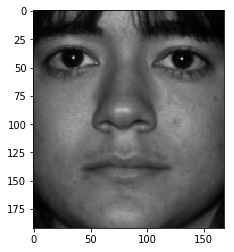

Emotion in the picture is :  neutral


In [277]:
#Testing with my own image
my_image = 'y31.jpg'
my_label = [5]
fname = 'test/'+my_image

image = cv2.imread(fname)
my_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
X_temp = []
X_temp.append(my_image)
X_temp = X_temp
X = np.array(X_temp)
X = X
print(X.shape)
X_flat = X.reshape(X.shape[0],-1).T
X_flat = X_flat/255.0
print(X_flat.shape)

p = np.zeros((train_y.shape[0],1))
prob,cache = L_model_forward(X_flat,parameters)
idx = np.argmax(prob[:,0],axis=0)
#j = 0
#maxs = prob[0,0]
#for i in range(0,train_y.shape[0]):
#    if prob[i,0]>maxs:
#        maxs = prob[i,0]
#        j = i
plt.imshow(image,interpolation='nearest')
plt.show()
print("Emotion in the picture is : ",type_y[idx])